In [1]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')

import seaborn as sns

from math import log10, floor

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



from sklearn.cluster import KMeans, MiniBatchKMeans

# CU Woot Math Method 2 for unsercived discovery of new behavior traits
## 1) Convert response field dictionary into a document
## 2) Develop word vector using term frequency - inverse document frequency
## 3) Use K-Means to cluster documents
## 4) Map traits to clusters to validate technique
## 5) Pick one qual_id and repeat clustering with failed sessions
## 6) 

In the first results presented to Woot Math a 100K sample of the entire data set was chosen. In this report, I'll start with the same type of analysis to develop the same heat map. In the meeting Sean and Brent suggested using just one of the qual_id and repeat the experiment and then look at the samples in clusers without traits.



## 1) Convert response field dictionary into a document


In [2]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")

Setup db access


In [3]:
#
# Get collections from mongodb
#
#db = client.my_test_db
db = client.test


In [4]:
chunk = 100000
start = 0
end = start + chunk

In [5]:
#reponses = db.anon_student_task_responses.find({'correct':False})[start:end]
reponses = db.anon_student_task_responses.find()[start:end]

In [6]:
df_responses = pd.DataFrame(list(reponses))

In [7]:
print (df_responses.shape)

(100000, 27)



## 2) Develop word vector using term frequency - inverse document frequency


In [8]:
##  Make the documents to be analyzed

In [9]:
## Functions for turning dictionary into document

def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
    
        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans

In [10]:
# Makes the cut & paste below easier
df3 = df_responses

In [11]:
df3['response_doc'] = df3['response'].map(make_string)


In [12]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace('/','_'))
df3['response_doc'] = df3['response_doc'] + ' ' + df3['txt'] 
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

## Sample Documents

In [13]:
for idx in range(20):
    print ("Sample number:", idx, "\n", df3.iloc[idx]['response_doc'])

Sample number: 0 
   fraction_cblock_chains_ right_442 fraction_cblock_chains_ sum_ numerator_1 sum_ denominator_2 sum_ __as3_type_Fraction fraction_cblock_chains_  pieces_1_2 fraction_cblock_chains_ left_97 fraction_cblock_chains_ lcm_sum_ numerator_1 lcm_sum_ denominator_2 lcm_sum_ __as3_type_Fraction   plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_end_marker_noline.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_start_marker.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_dog.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_cat_dog_trail.swf  den_2  fraction_input_value_1_2  num_1  fraction_cblock_total_count_1    fraction_cblock_counts_ 1_2_1   whole_   Use the 1/2 pieces to figure out how far the dog traveled.Answer: 1/2 
Sample number: 1 
  fraction_cb

In [14]:
data_samples = df3['response_doc']

## 3) Use K-Means to cluster documents

In [15]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [16]:
print("Extracting tf-idf features ...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features ...
done in 12.025s.


In [17]:
# Number of clusters
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, random_state=42)

In [18]:
print("Clustering with %s" % km)
t0 = time()
km.fit(tfidf)
print("done in %0.3fs" % (time() - t0))
print()

Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=42, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 4.487s



In [19]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:\n" % i, end='')
    for ind in order_centroids[i, :30]:
        print(' --- %s\n' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0:
 --- write
 --- used
 --- divideboth
 --- denominator
 --- numerator
 --- form
 --- simplest
 --- number
 --- enter
 --- divide
 --- answer
 --- 12
 --- 15
 --- 10
 --- den_8
 --- far
 --- line
 --- fraction_input_value_3_8
 --- whole_
 --- num_3
 --- fraction
 --- fraction_input_value_2_8
 --- fraction_input_value_1_8
 --- num_2
 --- num_1
 --- fraction_input_value_2_4
 --- fraction_circle_containment_
 --- fraction_circle_total_count_13
 --- fraction_input_value_3
 --- fraction_circle_total_count_12

Cluster 1:
 --- fraction_cblock_chains_
 --- pieces_1_8
 --- lcm_sum_
 --- sum_
 --- __as3_type_fraction
 --- denominator_8
 --- numerator_1
 --- denominator_1
 --- bar1_
 --- fraction_cblock_counts_
 --- fraction
 --- fraction_cblock_containment_
 --- numerator_8
 --- left_130
 --- denominator_4
 --- pieces_1
 --- numerator_5
 --- denominator_2
 --- numerator_3
 --- right_820
 --- left_176
 --- numerator_7
 --- left_100
 --- 1_4_
 --- 1_8_8
 --- bar2_
 

In [20]:
df3['cluster_100'] = km.labels_

In [21]:
df3['trait_1'] = df3['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )
df3['trait_2'] = df3['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 

In [22]:
df_trait_1 = df3.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)
df_trait_2 = df3.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)

In [23]:
df_cluster_100 = df3.groupby('cluster_100')

In [24]:
df_trait_1.index.rename('cluster_100', inplace=True)
df_trait_2.index.rename('cluster_100', inplace=True)
df_traits = pd.concat([df_trait_1, df_trait_2], axis=1)

In [25]:
df_traits = df_traits.drop('None', axis=1)

In [26]:
#df_traits_norm = (df_traits - df_traits.mean()) / (df_traits.max() - df_traits.min())
df_traits_norm = (df_traits  / (df_traits.sum()) )

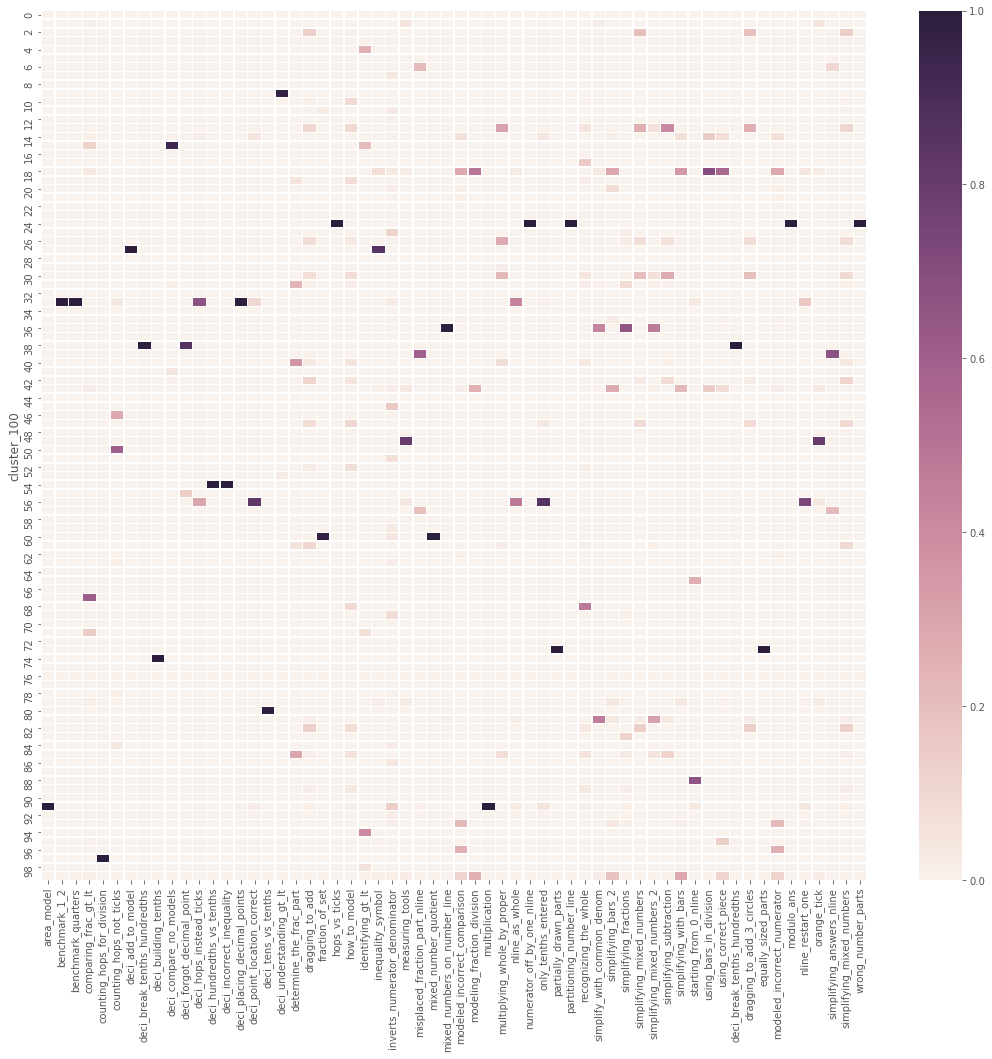

In [27]:
fig = plt.figure(figsize=(18.5, 16))
cmap = sns.cubehelix_palette(light=.95, as_cmap=True)
sns.heatmap(df_traits_norm, cmap=cmap,  linewidths=.5)

#sns.heatmap(df_traits_norm, cmap="YlGnBu",  linewidths=.5)

In [28]:
qids = db.anon_student_task_responses.distinct('qual_id')

In [29]:
qids = list(qids)

In [30]:
print (len(qids), qids)

27473 ['_Pd6uU3viE.parta.nvrm82_9Yv', '096-5s8eJ6.partb.jVG3p9f-20', 'z-FUzbs7Ez.parta._NUUDSBMum', 'z-FUzbs7Ez.parta.B6HmMEMpoL', 'EyVvIsCQCo.partb.IYWiIP26on', 'GQzhzHdUq_.set6.bUoNJIVgJi', 'BYGzN1ZApc.set2.39Y1vECA2c', 'BYGzN1ZApc.set3.faYl5HT_Sn', 'TJxldqZMXd.parta.jzC49--8x7', 'TJxldqZMXd.partb.hxS1eqLik1', 'TJxldqZMXd.partb.W2tLvQTbkI', 'JOD1-Zij75.partb.eKCslIK5ni', 'Lfm8VXz-oF.bonus15.a8xCwtQYH-', '_Pd6uU3viE.parta.vc55maq-Rm', '096-5s8eJ6.partb.lNxEwqVNhj', 'C2zASvJwfe.bonus.7czKTp17AW', 'ogme0bdOe3.parta.XyJVdG6_-8', '096-5s8eJ6.partb.jGq7IGYWTF', '_Pd6uU3viE.parta.gM26ScOfQr', '_Pd6uU3viE.parta.qrWIc3vNyV', 'zICSU-nesR.partb.w84rby06jn', 'ogme0bdOe3.parta.DWMh4Y7BQW', 'hHiTjKMgP4.parta.f9XfESw3sq', 'y0Bjb5gTe2.partb.qpXpIt2g3O', 'yIt5XijTTa.bonus.98JDhC48ny', 'FElR5ZJ2-D.parta.RWk6thwv7X', 'FElR5ZJ2-D.parta.lJZXpuGIxL', 'FElR5ZJ2-D.parta.ebOmOiHklV', 'piCaCJiyIo.parta.iFYu9imr7r', 'piCaCJiyIo.parta.TycwfEOe-0', 'piCaCJiyIo.parta.KlmUwiuqsE', 'piCaCJiyIo.parta.NlUnAY15Sv', 'G

In [31]:
q_counts = db.collection.aggregate(
    [
       { '$group' : { '_id': '$qual_id', 'count' : {'$sum' : 1}}}
    ]
)

In [32]:
df_responses.shape

(100000, 31)

In [33]:
df2 = df_responses.join(pd.DataFrame(df_responses["student"].to_dict()).T)

In [34]:
df2 = df2.join(pd.DataFrame(df2['level_summary'].to_dict()).T)

In [35]:
df2 = df2.join(pd.DataFrame(df2['problems'].to_dict()).T)

In [36]:
df3  = df2.copy()

In [37]:
df2.iloc[70]

_id                                              5a00f1739100de1a390001a8
behavioral_traits                                                      []
bonus                                                               False
correct                                                             False
diff                                                                    0
id                                                             q2ElZZuy7P
incomplete                                                          False
lesson                                                         division_8
level_summary           {'entered': True, 't_elapsed': 115577, 'unit_n...
problem_set             lessons/fractions/lesson85/part_b/media/proble...
problem_set_id                                                 qIkkuC4fAD
problem_set_subspace                                                partb
qual_id                                       qIkkuC4fAD.partb.q2ElZZuy7P
randomly_selected                     

In [38]:
data_samples = list(df3['response_doc'])

In [39]:
## Look act columns
print (df_responses.columns)

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'response_doc',
       'cluster_100', 'trait_1', 'trait_2'],
      dtype='object')


In [40]:
## How many data samples
print (len(df_responses), "Number of entries")

100000 Number of entries


In [41]:
## Make 'description' a feature wih important words mapped

In [42]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'response_doc',
       'cluster_100', 'trait_1', 'trait_2', 'grade', 'mvt_group',
       'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong'],
      dtype='object')

In [43]:
df3['percent_prob_correct'] = df3['nright'].astype(float) / df3['ntotal']

In [44]:
df3['qual_id'].unique()

array(['_Pd6uU3viE.parta.nvrm82_9Yv', '096-5s8eJ6.partb.jVG3p9f-20',
       'z-FUzbs7Ez.parta._NUUDSBMum', ..., 'HdvqniXBMa.parta.n0lbgKJV3M',
       'PiRuNU0bHe.parta.JC9B429KEH', 'FSOldX-rL7.partb.mnrdF_HvAf'], dtype=object)

In [45]:
df3.iloc[0]

_id                                              5a00f1739100de1a390000d0
behavioral_traits                                                      []
bonus                                                               False
correct                                                              True
diff                                                                    0
id                                                             nvrm82_9Yv
incomplete                                                          False
lesson                                                           nline_1b
level_summary           {'entered': True, 'path': 'nline_1b', 'lm_stat...
problem_set             lessons/fractions/lesson13_1/part_a/media/prob...
problem_set_id                                                 _Pd6uU3viE
problem_set_subspace                                                parta
qual_id                                       _Pd6uU3viE.parta.nvrm82_9Yv
randomly_selected                     

In [46]:
for idx in range(100):
    print ('index"', idx)
    print (df3.iloc[idx]['lesson'])
    print (df3.iloc[idx]['response'])

index" 0
nline_1b
{'fraction_cblock_chains': [{'right': 442, 'sum': {'numerator': 1, 'denominator': 2, '__as3_type': 'Fraction'}, 'pieces': ['1/2'], 'left': 97, 'lcm_sum': {'numerator': 1, 'denominator': 2, '__as3_type': 'Fraction'}}], 'plain_image_groups': [{'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/markers/end_marker_noline.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/dog.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/cat_dog_trail.swf'}], 'den': '2', 'fraction_input_value': '1/2', 'num': '1', 'fraction_cblock_total_count': 1, 'numberline_associations': [[]], 'fraction_cblock_counts': {'1/2': 1}, 'fraction_cblock_containment': {}, 'whole': ''}
index" 1
nline_1b
{'fraction_cblock_total_count': 4, 'plain_image_groups': [{'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/panda.swf'}, {'total': 1

In [47]:
def stringify_response(resp):
    my_val = str(resp).replace("': ","_")
    my_val = my_val.replace("_{"," ")
    my_val = my_val.replace("_[",", ")
    for c in [']','[','{','}',"'","",","]:
        my_val = my_val.replace(c,'')
    return my_val


In [48]:
stringify_response(df3.iloc[0]['response'])

'fraction_cblock_chains right_442 sum numerator_1 denominator_2 __as3_type_Fraction pieces 1/2 left_97 lcm_sum numerator_1 denominator_2 __as3_type_Fraction plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/markers/end_marker_noline.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/dog.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/cat_dog_trail.swf den_2 fraction_input_value_1/2 num_1 fraction_cblock_total_count_1 numberline_associations  fraction_cblock_counts 1/2_1 fraction_cblock_containment  whole_'

In [49]:
df3['response_str'] = df3['response'].apply(stringify_response)

In [50]:
for idx in range(20):
    print (idx, df3['response_str'].iloc[idx])

0 fraction_cblock_chains right_442 sum numerator_1 denominator_2 __as3_type_Fraction pieces 1/2 left_97 lcm_sum numerator_1 denominator_2 __as3_type_Fraction plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/markers/end_marker_noline.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/dog.swf total_1 url_assets/cms/wootmath_fractions/number_line/objects/cat_dog_trail.swf den_2 fraction_input_value_1/2 num_1 fraction_cblock_total_count_1 numberline_associations  fraction_cblock_counts 1/2_1 fraction_cblock_containment  whole_
1 fraction_cblock_total_count_4 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/objects/panda.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf input_4 fraction_cblock_chains right_856 sum numerator_1 denominator_1 __as3_type_Fraction pieces 1/4 1/4 1/4 1/4 left_165 lcm_sum numerator_4 denomina

In [51]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'response_doc',
       'cluster_100', 'trait_1', 'trait_2', 'grade', 'mvt_group',
       'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong', 'percent_prob_correct',
       'response_str'],
      dtype='object')

In [52]:
## In Response:
### convert K, V, and all K_V into words in a text doc
### Then add text
### The add description


In [53]:
def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
        

        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans
        
            
        
            
            

In [54]:
df3['response_doc'] = df3['response'].map(make_string)

In [55]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [56]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace('/','_'))

In [57]:
df3['response_doc'] = df3['response_doc'] + ' ' + df3['txt'] 

In [58]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [59]:
df3['response_doc'] = df3['response_doc'] +  ' ' + df3['description']

In [60]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))

In [61]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

In [62]:
df3.iloc[100]['response_doc']

" radio_group_mc2_ choice_A radio_group_mc2_ text_Yes  radio_group_mc1_ choice_B radio_group_mc1_ text_No   plain_image_groups_ url_assets_cms_wootmath_fractions_equal_parts_sixths_sixth_15.swf plain_image_groups_ total_1  plain_image_groups_ url_assets_cms_wootmath_fractions_equal_parts_sixths_sixth_06.swf plain_image_groups_ total_1   Do these shapes have 5/6 shaded Answer: [object Object]  Students deepen their understanding of fractions by identifying area models that are divided into equal parts and those that aren't. "

In [63]:
df3.iloc[100]['response']

{'plain_image_groups': [{'total': 1,
   'url': 'assets/cms/wootmath_fractions/equal_parts/sixths/sixth_15.swf'},
  {'total': 1,
   'url': 'assets/cms/wootmath_fractions/equal_parts/sixths/sixth_06.swf'}],
 'radio_group_mc1': {'choice': 'B', 'text': 'No'},
 'radio_group_mc2': {'choice': 'A', 'text': 'Yes'}}

In [64]:
df3.iloc[100]

_id                                              5a00f1739100de1a390001fa
behavioral_traits                                                      []
bonus                                                               False
correct                                                              True
diff                                                             0.304348
id                                                             Z3I2H8eOfO
incomplete                                                          False
lesson                                                      parts_whole_1
level_summary           {'subject': 'fractions', 'path': 'parts_whole_...
problem_set             lessons/fractions/lesson07/eq_parts/media/prob...
problem_set_id                                                 6nBHKepQ3Y
problem_set_subspace                                                 set2
qual_id                                        6nBHKepQ3Y.set2.Z3I2H8eOfO
randomly_selected                     

In [65]:
for idx in range(20):
    print (idx, df3['response_doc'].iloc[idx])

0   fraction_cblock_chains_ right_442 fraction_cblock_chains_ sum_ numerator_1 sum_ denominator_2 sum_ __as3_type_Fraction fraction_cblock_chains_  pieces_1_2 fraction_cblock_chains_ left_97 fraction_cblock_chains_ lcm_sum_ numerator_1 lcm_sum_ denominator_2 lcm_sum_ __as3_type_Fraction   plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_end_marker_noline.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_start_marker.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_dog.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_cat_dog_trail.swf  den_2  fraction_input_value_1_2  num_1  fraction_cblock_total_count_1    fraction_cblock_counts_ 1_2_1   whole_   Use the 1/2 pieces to figure out how far the dog traveled.Answer: 1/2  In the first part of this lesson, student partit

In [66]:
#df3['response_doc'] = df3['response_doc'].map( lambda x: " ".join(x.split('/')) if '/' in x else x)

In [67]:
df3.iloc[100]['response_doc']

" radio_group_mc2_ choice_A radio_group_mc2_ text_Yes  radio_group_mc1_ choice_B radio_group_mc1_ text_No   plain_image_groups_ url_assets_cms_wootmath_fractions_equal_parts_sixths_sixth_15.swf plain_image_groups_ total_1  plain_image_groups_ url_assets_cms_wootmath_fractions_equal_parts_sixths_sixth_06.swf plain_image_groups_ total_1   Do these shapes have 5/6 shaded Answer: [object Object]  Students deepen their understanding of fractions by identifying area models that are divided into equal parts and those that aren't. "

In [68]:
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace('[',' '))
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace(']',' '))

In [69]:
df3.iloc[100]['response_doc']

" radio_group_mc2_ choice_A radio_group_mc2_ text_Yes  radio_group_mc1_ choice_B radio_group_mc1_ text_No   plain_image_groups_ url_assets_cms_wootmath_fractions_equal_parts_sixths_sixth_15.swf plain_image_groups_ total_1  plain_image_groups_ url_assets_cms_wootmath_fractions_equal_parts_sixths_sixth_06.swf plain_image_groups_ total_1   Do these shapes have 5/6 shaded Answer:  object Object   Students deepen their understanding of fractions by identifying area models that are divided into equal parts and those that aren't. "

In [70]:
for idx in range(10):
    print ('Cluster ', + idx, ': ' + df3.iloc[idx]['response_doc'])

Cluster  0 :   fraction_cblock_chains_ right_442 fraction_cblock_chains_ sum_ numerator_1 sum_ denominator_2 sum_ __as3_type_Fraction fraction_cblock_chains_  pieces_1_2 fraction_cblock_chains_ left_97 fraction_cblock_chains_ lcm_sum_ numerator_1 lcm_sum_ denominator_2 lcm_sum_ __as3_type_Fraction   plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_end_marker_noline.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_start_marker.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_dog.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_cat_dog_trail.swf  den_2  fraction_input_value_1_2  num_1  fraction_cblock_total_count_1    fraction_cblock_counts_ 1_2_1   whole_   Use the 1/2 pieces to figure out how far the dog traveled.Answer: 1/2  In the first part of this lesson, stu

In [71]:
data_samples = list(df3['response_doc'])

In [72]:
data_samples = docs

NameError: name 'docs' is not defined

In [ ]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [ ]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [ ]:
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


In [ ]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


In [ ]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 100
n_top_words = 30

In [ ]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


In [ ]:

from sklearn.cluster import KMeans, MiniBatchKMeans
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, random_state=42)

In [ ]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(tf)
print("done in %0.3fs" % (time() - t0))
print()

In [ ]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:\n" % i, end='')
    for ind in order_centroids[i, :30]:
        print(' --- %s\n' % terms[ind], end='')
    print()

In [ ]:
len(km.labels_)

In [ ]:
np.bincount(km.labels_)

In [ ]:
df3['cluster_100'] = km.labels_

In [ ]:
len(np.bincount(km.labels_))

In [ ]:
df3.shape

In [ ]:
df3['cluster_100'] = km.labels_


In [ ]:
df3['trait_1'] = df3['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )

In [ ]:
df3['trait_2'] = df3['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 

In [ ]:
df3['trait_1'].value_counts()

In [ ]:
df3['trait_2'].value_counts()

In [ ]:
df_cluster_100 = df3.groupby('cluster_100')

In [ ]:
len(df_cluster_100)

In [ ]:
#df_cluster_100.head()

In [ ]:
df_pcorrect = df3['percent_prob_correct'].groupby(df3['cluster_100']).describe()

In [ ]:
df_pcorrect['mean'].hist()

In [ ]:
df_correct = df3['correct'].groupby(df3['cluster_100']).mean()

In [ ]:
df_correct.hist()

In [ ]:
df_true = df3[df3['correct']==True]
df_correctx_true = df_true['percent_prob_correct']

In [ ]:
df_correctx_true.hist()

In [ ]:
df_false = df3[df3['correct']!=True]
df_correctx_false = df_false['percent_prob_correct']

In [ ]:
df_correctx_false.hist()

In [ ]:
df_trait_1 = df3.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)

In [ ]:
df_trait_2 = df3.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)

In [ ]:
#df_trait_2

In [ ]:
df_trait_2.columns

In [ ]:
df_trait_1.columns

In [ ]:
[x for x in df_trait_2.columns if x not in df_trait_1.columns ]

In [ ]:
[x for x in df_trait_1.columns if x not in df_trait_2.columns ]

In [ ]:
#df_trait_1 = df_trait_1.drop('None', axis=1)
#df_trait_2 = df_trait_2.drop('None', axis=1)

In [ ]:
df_traits = pd.merge(left=df_trait_1,right=df_trait_2, how='left' )


In [ ]:
df_trait_1.index.rename('cluster_100', inplace=True)

In [ ]:
df_trait_2.index.rename('cluster_100', inplace=True)

In [ ]:
df_traits.columns

In [ ]:
df_traits = pd.concat([df_trait_1, df_trait_2], axis=1)

In [ ]:
print (df_traits.shape)
print (df_trait_1.shape)
print (df_trait_2.shape)


In [ ]:
df_traits.columns

In [ ]:
df_traits = df_traits.groupby(df_traits.columns, axis=1).sum()

In [ ]:
#df_traits

In [ ]:
df_traits = df_traits.drop('None', axis=1)

In [ ]:
#df_traits

In [ ]:
import seaborn as sns

In [ ]:
df_traits_dict = df_traits.to_dict()

In [ ]:
df_traits_dict_cluster = df_traits.transpose().to_dict()

In [ ]:
df_traits_dict_cluster_no0 = {}
for cluster, trait_dict in df_traits_dict_cluster.items():
    # print (cluster, trait_dict)
    df_traits_dict_cluster_no0[cluster] = { k:v for k,v in trait_dict.items() if v != 0}

In [ ]:
df_traits_dict_cluster_no0[88]

In [ ]:
df_traits_dict_cluster_no0[40]

In [ ]:
print (sorted(list(df_traits.columns)))

In [ ]:
temp = (sorted(list(df_traits.columns)))
for idx, x in enumerate(temp):
    if idx > 0:
        if x == temp[idx - 1]:
            print (x)

In [ ]:
#df_traits_norm = (df_traits - df_traits.mean()) / (df_traits.max() - df_traits.min())
df_traits_norm = (df_traits  / (df_traits.sum()) )

In [ ]:
df_traits_norm = df_traits_norm.applymap( lambda x: 0 if x < 0 else x)

In [ ]:
#df_traits_norm

In [ ]:
fig = plt.figure(figsize=(18.5, 16))
cmap = sns.cubehelix_palette(light=.95, as_cmap=True)
sns.heatmap(df_traits_norm, cmap=cmap,  linewidths=.5)

#sns.heatmap(df_traits_norm, cmap="YlGnBu",  linewidths=.5)

In [ ]:
df_traits_norm.shape

In [ ]:
fig.savefig('heat_map_100_2.png')


In [ ]:

#df_traits.plot.bar(stacked=True, figsize=(18.5, 16), legend=False)

In [ ]:
df_traits.to_csv('cluster_100.csv')

In [ ]:
df_traits2 = pd.concat([df3['percent_prob_correct'].groupby(df3['cluster_100']).describe(), df_traits], axis=1)

In [ ]:
df_traits2.to_csv('cluster_100_plus_correct.csv')

In [ ]:
df_traits_dict = df_traits.to_dict(orient='dict')

In [ ]:
#df_traits_dict

In [ ]:
df_traits_dict2 = {}
cluster_with_no_trait = list(np.arange(100))
cluster_with_lt_10_trait = list(np.arange(100))

In [ ]:
for trait in df_traits_dict:
    #print (idx, trait)
    df_traits_dict2[trait] = {}
    for cluster in df_traits_dict[trait]:
        #print (trait, cluster, df_traits_dict[trait][cluster])
        if  df_traits_dict[trait][cluster] > 0:
            df_traits_dict2[trait][cluster] = df_traits_dict[trait][cluster]
            if cluster in cluster_with_no_trait:
                cluster_with_no_trait.remove(cluster)
            if  df_traits_dict[trait][cluster] > 9:
                if cluster in cluster_with_lt_10_trait:
                    cluster_with_lt_10_trait.remove(cluster)

In [ ]:
print (df_traits_dict2)

In [ ]:
cluster_with_no_trait, 

In [ ]:
len(cluster_with_no_trait)

In [ ]:
len(cluster_with_lt_10_trait)

In [ ]:
x = list(df_traits.index)

In [ ]:
df_traits.shape

In [ ]:
y = df_traits.sum(axis=1)

In [ ]:
y

In [ ]:

plt.bar( x, y)


In [ ]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster')
ax.set_title('Traits per cluster')



In [ ]:
counts_per_cluster = np.bincount(km.labels_)

In [ ]:
print (counts_per_cluster)

In [ ]:
counts_per_cluster = list(counts_per_cluster)

In [ ]:
counts_per_cluster = [x for x in counts_per_cluster if x != 0]

In [ ]:
counts_per_cluster = np.array(counts_per_cluster)

In [ ]:
y1 = y / counts_per_cluster

In [ ]:
#y

In [ ]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y1, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster/ total response at cluster')
ax.set_title('Traits per cluster')

In [ ]:
df_traits2p = df_traits2.copy()

In [ ]:
df_traits2p['num_correct_true'] = df3.groupby('cluster_100')['correct'].apply(lambda x: (x==True).sum())

In [ ]:
df_traits2p['percent_correct_true'] = (df_traits2p['num_correct_true']/df_traits2p['count'])*100.0

In [ ]:
df_traits2p.drop('num_correct_true', axis=1, inplace=True)

In [ ]:
#df_traits2p

In [ ]:
#df_traits2

In [ ]:
df_percent_prob_correct = df_traits2['mean']

In [ ]:
df_percent_prob_correct.plot.bar(figsize=(17,12), title='Percent problems correct in a lesson per cluster')

In [ ]:
df_percent_correct_true = df_traits2p['percent_correct_true']

In [ ]:
df_percent_correct_true.plot.bar(figsize=(17,12), title='Percent correct=True per cluster')

In [ ]:
df_sample_size = df_traits2p['count']

In [ ]:
df_sample_size.plot.bar(figsize=(17,12), title='Samples per cluster, 100K data points')

In [ ]:
df_trait_dict = df_traits.transpose().to_dict()

In [ ]:
df_trait_dict_new = defaultdict()
for cluster in df_trait_dict:
    # print (cluster,df_trait_dict[cluster])
    df_trait_dict_new[cluster] = defaultdict()
    for trait in df_trait_dict[cluster]:
        # print (trait, df_trait_dict[cluster][trait])
        if df_trait_dict[cluster][trait] != 0:
            df_trait_dict_new[cluster][trait] = df_trait_dict[cluster][trait]
        

In [ ]:
#df_trait_dict_new

In [ ]:
sums = df_traits.sum()

In [ ]:
df_traits_pct = df_traits/sums * 100.0

In [ ]:
ax = df_traits_pct.plot.bar(stacked=True, figsize=(18.5, 16), legend=False, title='Per Trait (Color is Trait) percent (of 100%) at Each Cluster')
ax.set_ylabel("Percent (of 100) of trait")

In [ ]:
df_traits_pct_dict = df_traits_pct.transpose().to_dict()

In [ ]:
df_traits_pct_dict_new = defaultdict()

In [ ]:
for cluster in df_traits_pct_dict:
    #print (cluster,df_traits_pct_dict[cluster])
    df_traits_pct_dict_new[cluster] = defaultdict()
    for trait in df_traits_pct_dict[cluster]:
        # print (trait, df_traits_pct_dict[cluster][trait])
        if df_traits_pct_dict[cluster][trait] > 5:
            df_traits_pct_dict_new[cluster][trait] = df_traits_pct_dict[cluster][trait]
        

In [ ]:
for key in df_traits_pct_dict_new:
    print ("Cluster {0} -- count of samples in this cluster {1} percent correct={2:.1f}".
               format(key, df_traits2.iloc[key]['count'],df_traits2p.iloc[key]['percent_correct_true'] ))
    if len(df_traits_pct_dict_new[key]) < 1:
        print ("None")
    else:
        for trait in df_traits_pct_dict_new[key]:
            print (' -- ' + str(trait) + ' : '  + "{0:.1f}".format(df_traits_pct_dict_new[key][trait]))